# Lab 7  Recurrent Network Architectures —— Movie Reviews

47491968 Yuankai Liu      
47511663 Jianing Zhao     
47564911 Yang Peng

# 1.Preparation

In lab 7, we will  be using the movie review dataset, which includes 2000 movie reviews. Available are collections of movie-review documents labeled with respect to their overall sentiment polarity (positive or negative). There are 1000 positive and 1000 negative processed reviews.

## 1.1  Define and prepare the class variables

Import the polarity dataset v2.0.

http://www.cs.cornell.edu/people/pabo/movie-review-data/


In [278]:
import os  
import pandas as pd  
from sklearn.model_selection import StratifiedKFold

In [56]:

alldata=[]
y=[]

for info in os.listdir(r'E:\2018spring\CSE7324MachineLearning\MLlab\lab7\data\pos'):
    domain = os.path.abspath(r'E:\2018spring\CSE7324MachineLearning\MLlab\lab7\data\pos')
    info = os.path.join(domain,info) 
    info = open(info,'r') 
    alldata.append(info.read())
    y.append(0)
    info.close()
    
for info in os.listdir(r'E:\2018spring\CSE7324MachineLearning\MLlab\lab7\data\neg'):
    domain = os.path.abspath(r'E:\2018spring\CSE7324MachineLearning\MLlab\lab7\data\neg') 
    info = os.path.join(domain,info) 
    info = open(info,'r') 
    alldata.append(info.read())
    y.append(1)
    info.close()

In [87]:
l=[]
for pa in alldata:
    l.append(pa.count(' '))

The figure below shows the distribution of these reviews and the most length of movie reviews in this dataset is between 500 and 1000. Therefore, we decided to set 1500 as the max length for our model.

Text(0.5,1,'Distribution of the length of reviews')

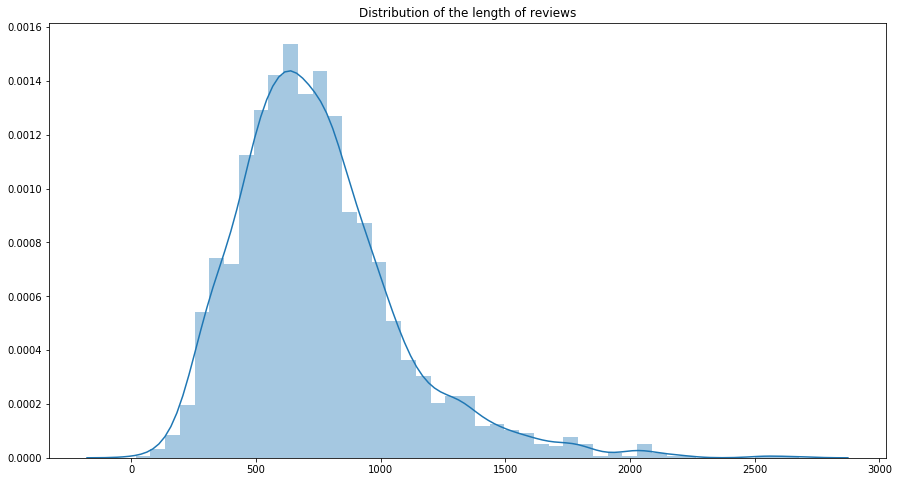

In [279]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.distplot(l)
plt.title('Distribution of the length of reviews')

In [89]:
%%time
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = 10000
MAX_ART_LEN = 1500

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(alldata)
sequences = tokenizer.texts_to_sequences(alldata)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 43296 unique tokens. Distilled to 10000 top words.
Shape of data tensor: (2000, 1500)
Shape of label tensor: (2000, 2)
9999
Wall time: 1.03 s


Tranfer each original movie review to sequence data. The final dataset is a form of 2D numpy array.

## 1.2  Evaluation Metrics

Genarally, We use accuracy, precision, recall, f1-score, ROC-AUC to evalate the model in binary classification problems.

__Accuracy__: It is the most common and basic evaluation metric.

__Precision__: It is the proportion of "true" samples judged by all systems that is truly true, that is, TP/(TP+FP).

__Recall__: It is the proportion of “true” that is judged to be TP/(TP+FN) in all samples that are truly true.

__F1-score__: The metric designed to comprehensively consider the precision and recall.

__ROC-AUC__: It is the curve of TP vs FP.


But the objective in different situation is totally diferent, which means that the quality of metrics depends on the goals of the classifier. __For instance__, email filtering spam, you want it to be more comprehensive (detect all the junk, but there is a lot of useful information is also judged as junk), or you want it to be as accurate as possible (do not always detect useful email as junk)? Obviously, we think that False Positive's damage is greater than False Negative: the loss of important mail if it is sentenced to junk is far greater than the amount of spam in the inbox. __However__, for the prediction of the earthquake, we hope that recall is very high, that is, we want to predict each earthquake. At this time we can sacrifice percision.

In this lab, as we stated before, our binary classification problem aims to predict the atitude of movie reviews. Stakeholders can use these analysis to evaluate the quality of a movie, we believe that we are concerned about True-Positive and Ture-Negative equally and they have the same importance. Given the analysis above of our business case, we think that the most appropriate evaluation metric for our model would be **F1-score**. We decided to use F1-score as our evaluation metric.


## 1.3 Training/Testing Split and Cross validation method

In addition to deciding on an evaluation metric that is more appropriate for our business use case, we must also determine the best method by which to divide our data into training and testing splits. Our dataset are 2000 movie reviews.

First of all, We should split dataset into training set and testing set. Then we need to split our training set into real training set and validation set, and the process of splits are stratified. 10 folds is a common number of folds that gets used in cross validation techniques, but we found that the training time of each RNN model is greatly increased relative to our previous work, just like CNN. Cross validation is a good method to improve the performace of model especially in small dataset, the more bigger dataset has the less reliance of cross validation. In the cases of time and the size of our dataset, we would want to use a stratified 2-fold cross validation to help us get better performance of our model. 

we will be applying cross validation in our modeling part. 

In [184]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify=y, 
                                                            random_state=42)
y_train_ohe= keras.utils.to_categorical(y_train)
y_test_ohe= keras.utils.to_categorical(y_test)

NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(1600, 1500) (1600, 2)
[ 800.  800.]


# 2.Modeling

For our classification model, we will be experimenting with three different recurrent neural networks and then add a second recurrent chain by using the best RNN architecture.

## 2.1 Three RNN Models

Words embedding

In [108]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

Found 400000 word vectors.
(43297, 100)
Wall time: 9.21 s


We found that F1-score evaluation has been deleted from Keras, and if we want to use F1-score, we should define this function and we can use this function in our RNN model to see the scores in each epoch.

In [141]:
from keras import backend as K
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [392]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout,Activation
from keras.layers import LSTM, GRU, SimpleRNN,TimeDistributed
from keras.layers.embeddings import Embedding

__First model__

We used LSTM architecture.

In [157]:
#model 1
rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[f1])
print(rnn.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 100)         4329700   
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 202       
Total params: 4,410,302
Trainable params: 80,602
Non-trainable params: 4,329,700
_________________________________________________________________
None


__Second model__

We used GRU architecture.

In [158]:
#model2
rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn2.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[f1])
print(rnn2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 100)         4329700   
_________________________________________________________________
gru_9 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 202       
Total params: 4,390,202
Trainable params: 60,502
Non-trainable params: 4,329,700
_________________________________________________________________
None


__Third model__

We used GRU architecture and added dropoff layer and dense layer.

In [159]:
#model3
rnn3 = Sequential()
rnn3.add(embedding_layer)
rnn3.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn3.add(Dense(100,activation='relu'))
rnn3.add(Dropout(0.5))
rnn3.add(Dense(NUM_CLASSES, activation='sigmoid'))

rnn3.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[f1])
print(rnn3.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 100)         4329700   
_________________________________________________________________
gru_10 (GRU)                 (None, 100)               60300     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 202       
Total params: 4,400,302
Trainable params: 70,602
Non-trainable params: 4,329,700
_________________________________________________________________
None


Here we tried to tune the parameters like epoch and to find a proper epoch for us to perform cross-validation.

In [160]:
h1=rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=40, batch_size=64)

Train on 1600 samples, validate on 400 samples
Epoch 1/40
1600/1600 [==============================] - 59s 37ms/step - loss: 0.6865 - f1: 0.5415 - val_loss: 0.7017 - val_f1: 0.4987
Epoch 2/40
1600/1600 [==============================] - 57s 35ms/step - loss: 0.6738 - f1: 0.5779 - val_loss: 0.6673 - val_f1: 0.5890
Epoch 3/40
1600/1600 [==============================] - 56s 35ms/step - loss: 0.6552 - f1: 0.6145 - val_loss: 0.6362 - val_f1: 0.6619
Epoch 4/40
1600/1600 [==============================] - 56s 35ms/step - loss: 0.6519 - f1: 0.6130 - val_loss: 0.6303 - val_f1: 0.6621
Epoch 5/40
1600/1600 [==============================] - 56s 35ms/step - loss: 0.6376 - f1: 0.6378 - val_loss: 0.6413 - val_f1: 0.6239
Epoch 6/40
1600/1600 [==============================] - 56s 35ms/step - loss: 0.6269 - f1: 0.6435 - val_loss: 0.6410 - val_f1: 0.6271
Epoch 7/40
1600/1600 [==============================] - 56s 35ms/step - loss: 0.6313 - f1: 0.6380 - val_loss: 0.5925 - val_f1: 0.6848
Epoch 8/40
1600

In [161]:
h2=rnn2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=40, batch_size=64)

Train on 1600 samples, validate on 400 samples
Epoch 1/40
1600/1600 [==============================] - 47s 29ms/step - loss: 0.6967 - f1: 0.5302 - val_loss: 0.6820 - val_f1: 0.5857
Epoch 2/40
1600/1600 [==============================] - 46s 29ms/step - loss: 0.6739 - f1: 0.5850 - val_loss: 0.6764 - val_f1: 0.5853
Epoch 3/40
1600/1600 [==============================] - 47s 29ms/step - loss: 0.6580 - f1: 0.6069 - val_loss: 0.6655 - val_f1: 0.6144
Epoch 4/40
1600/1600 [==============================] - 47s 29ms/step - loss: 0.6551 - f1: 0.6134 - val_loss: 0.6602 - val_f1: 0.5681
Epoch 5/40
1600/1600 [==============================] - 47s 29ms/step - loss: 0.6397 - f1: 0.6395 - val_loss: 0.6558 - val_f1: 0.5620
Epoch 6/40
1600/1600 [==============================] - 47s 29ms/step - loss: 0.6287 - f1: 0.6524 - val_loss: 0.6320 - val_f1: 0.6648
Epoch 7/40
1600/1600 [==============================] - 49s 31ms/step - loss: 0.6008 - f1: 0.6818 - val_loss: 0.6083 - val_f1: 0.6548
Epoch 8/40
1600

In [162]:
h3=rnn3.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=40, batch_size=64)

Train on 1600 samples, validate on 400 samples
Epoch 1/40
1600/1600 [==============================] - 58s 36ms/step - loss: 0.7022 - f1: 0.5044 - val_loss: 0.6874 - val_f1: 0.5703
Epoch 2/40
1600/1600 [==============================] - 53s 33ms/step - loss: 0.6883 - f1: 0.5379 - val_loss: 0.6795 - val_f1: 0.5913
Epoch 3/40
1600/1600 [==============================] - 52s 32ms/step - loss: 0.6780 - f1: 0.5696 - val_loss: 0.6711 - val_f1: 0.6105
Epoch 4/40
1600/1600 [==============================] - 52s 32ms/step - loss: 0.6678 - f1: 0.5860 - val_loss: 0.6570 - val_f1: 0.6269
Epoch 5/40
1600/1600 [==============================] - 52s 32ms/step - loss: 0.6603 - f1: 0.6048 - val_loss: 0.6662 - val_f1: 0.6127
Epoch 6/40
1600/1600 [==============================] - 52s 33ms/step - loss: 0.6518 - f1: 0.6188 - val_loss: 0.6354 - val_f1: 0.6267
Epoch 7/40
1600/1600 [==============================] - 52s 33ms/step - loss: 0.6388 - f1: 0.6421 - val_loss: 0.6315 - val_f1: 0.6684
Epoch 8/40
1600

Below are the figures of F1-scores in each epoch.

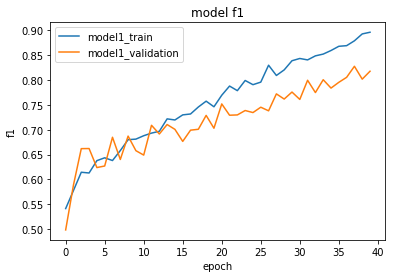

In [193]:
plt.plot()  
plt.plot(h1.history['f1'])
plt.plot(h1.history['val_f1'])
plt.title('model f1')  
plt.ylabel('f1')  
plt.xlabel('epoch')  
plt.legend(['model1_train', 'model1_validation'], loc='best')  
plt.show()  

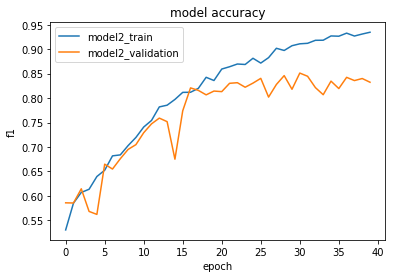

In [191]:
plt.plot()  
plt.plot(h2.history['f1'])
plt.plot(h2.history['val_f1'])
plt.title('model f1')  
plt.ylabel('f1')  
plt.xlabel('epoch')  
plt.legend(['model2_train', 'model2_validation'], loc='best')  
plt.show()  

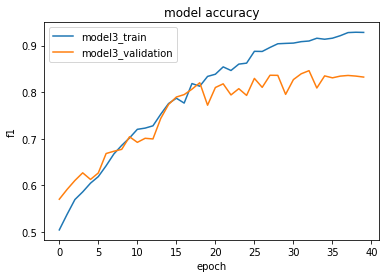

In [192]:
plt.plot()  
plt.plot(h3.history['f1'])
plt.plot(h3.history['val_f1'])
plt.title('model f1')  
plt.ylabel('f1')  
plt.xlabel('epoch')  
plt.legend(['model3_train', 'model3_validation'], loc='best')  
plt.show()  

Here we can see the F1-score changes intuitively, and finally we choose 25 epochs to make cross-validation models.

## 2.2 Two Chains RNN Model

Using the best RNN parameters and architecture (Third Model), add a second recurrent chain to the original RNN. 

In [280]:
#model4
rnn4 = Sequential()
rnn4.add(embedding_layer)
rnn4.add(GRU(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
rnn4.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn4.add(Dense(100,activation='relu'))
rnn4.add(Dropout(0.5))
rnn4.add(Dense(NUM_CLASSES, activation='sigmoid'))

rnn4.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[f1])
print(rnn4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 100)         4329700   
_________________________________________________________________
gru_28 (GRU)                 (None, 1500, 100)         60300     
_________________________________________________________________
gru_29 (GRU)                 (None, 100)               60300     
_________________________________________________________________
dense_57 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 2)                 202       
Total params: 4,460,602
Trainable params: 130,902
Non-trainable params: 4,329,700
____________________________________________________________

Here we also tried 40 epochs to see the changes of F1-scores.

In [173]:
h4=rnn4.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=40, batch_size=64)

Train on 1600 samples, validate on 400 samples
Epoch 1/40
1600/1600 [==============================] - 211s 132ms/step - loss: 0.6966 - f1: 0.5186 - val_loss: 0.6881 - val_f1: 0.4695
Epoch 2/40
1600/1600 [==============================] - 212s 133ms/step - loss: 0.6888 - f1: 0.5431 - val_loss: 0.6689 - val_f1: 0.6335
Epoch 3/40
1600/1600 [==============================] - 219s 137ms/step - loss: 0.6752 - f1: 0.5909 - val_loss: 0.6506 - val_f1: 0.6236
Epoch 4/40
1600/1600 [==============================] - 226s 141ms/step - loss: 0.6625 - f1: 0.6140 - val_loss: 0.6505 - val_f1: 0.6138
Epoch 5/40
1600/1600 [==============================] - 231s 144ms/step - loss: 0.6676 - f1: 0.6050 - val_loss: 0.6759 - val_f1: 0.5998
Epoch 6/40
1600/1600 [==============================] - 221s 138ms/step - loss: 0.6511 - f1: 0.6253 - val_loss: 0.6211 - val_f1: 0.6554
Epoch 7/40
1600/1600 [==============================] - 227s 142ms/step - loss: 0.6480 - f1: 0.6194 - val_loss: 0.6323 - val_f1: 0.6586
E

We run 20 extra epochs.

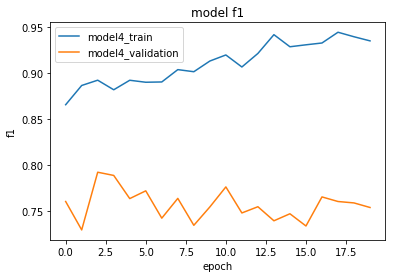

In [282]:
plt.plot()  
plt.plot(h4.history['f1'])
plt.plot(h4.history['val_f1'])
plt.title('model f1')  
plt.ylabel('f1')  
plt.xlabel('epoch')  
plt.legend(['model4_train', 'model4_validation'], loc='best')  
plt.show()  

We found that after adding a second recurrent chain to our RNN, there was not helpful to the results of F1-scores of our model. Meanwhile, it need much more running time.

## 2.3 Visualize the results of all the RNNs

We defined a function to run four model by using 2-fold cross_validation.

In [189]:
def creatrnn():

    #model 1
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f1])
    #model2
    rnn2 = Sequential()
    rnn2.add(embedding_layer)
    rnn2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
    rnn2.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn2.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f1])
    #model3
    rnn3 = Sequential()
    rnn3.add(embedding_layer)
    rnn3.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
    rnn3.add(Dense(100,activation='relu'))
    rnn3.add(Dropout(0.5))
    rnn3.add(Dense(NUM_CLASSES, activation='sigmoid'))

    rnn3.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f1])
    
    #two rnn layers
    rnn4 = Sequential()
    rnn4.add(embedding_layer)
    rnn4.add(GRU(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
    rnn4.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
    rnn4.add(Dense(100,activation='relu'))
    rnn4.add(Dropout(0.5))
    rnn4.add(Dense(NUM_CLASSES, activation='sigmoid'))

    rnn4.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f1])
    return rnn,rnn2,rnn3,rnn4

The epoch we set is 25, and this is the trade-off between running time and F1-score performance.

In [277]:
model_list=[]
history_list= []
skf = StratifiedKFold(n_splits=2, shuffle=True,)
epochs=25
for _, (train_indices, validation_indices) in enumerate(skf.split(X_train, y_train)):
    rnn,rnn2,rnn3,rnn4=creatrnn()
    history_list.append(rnn.fit(X_train[train_indices], y_train_ohe[train_indices], validation_data=(X_train[validation_indices], y_train_ohe[validation_indices]), epochs=25, batch_size=64))
    history_list.append(rnn2.fit(X_train[train_indices], y_train_ohe[train_indices], validation_data=(X_train[validation_indices], y_train_ohe[validation_indices]), epochs=25, batch_size=64))
    history_list.append(rnn3.fit(X_train[train_indices], y_train_ohe[train_indices], validation_data=(X_train[validation_indices], y_train_ohe[validation_indices]), epochs=25, batch_size=64))
    history_list.append(rnn4.fit(X_train[train_indices], y_train_ohe[train_indices], validation_data=(X_train[validation_indices], y_train_ohe[validation_indices]), epochs=25, batch_size=64))
    model_list.append(rnn)
    model_list.append(rnn2)
    model_list.append(rnn3)
    model_list.append(rnn4)

Train on 800 samples, validate on 800 samples
Epoch 1/25
800/800 [==============================] - 46s 57ms/step - loss: 0.6940 - f1: 0.5298 - val_loss: 0.6946 - val_f1: 0.5159
Epoch 2/25
800/800 [==============================] - 45s 57ms/step - loss: 0.6766 - f1: 0.5783 - val_loss: 0.6870 - val_f1: 0.5468
Epoch 3/25
800/800 [==============================] - 45s 57ms/step - loss: 0.6596 - f1: 0.6196 - val_loss: 0.6763 - val_f1: 0.6050
Epoch 4/25
800/800 [==============================] - 45s 57ms/step - loss: 0.6421 - f1: 0.6548 - val_loss: 0.6815 - val_f1: 0.5582
Epoch 5/25
800/800 [==============================] - 45s 56ms/step - loss: 0.6327 - f1: 0.6449 - val_loss: 0.7109 - val_f1: 0.5307
Epoch 6/25
800/800 [==============================] - 45s 57ms/step - loss: 0.6254 - f1: 0.6567 - val_loss: 0.6623 - val_f1: 0.6108
Epoch 7/25
800/800 [==============================] - 44s 56ms/step - loss: 0.6268 - f1: 0.6382 - val_loss: 0.6597 - val_f1: 0.6135
Epoch 8/25
800/800 [==========

Epoch 12/25
800/800 [==============================] - 35s 44ms/step - loss: 0.5928 - f1: 0.6736 - val_loss: 0.6727 - val_f1: 0.6014
Epoch 13/25
800/800 [==============================] - 36s 45ms/step - loss: 0.5827 - f1: 0.7080 - val_loss: 0.6689 - val_f1: 0.6122
Epoch 14/25
800/800 [==============================] - 35s 44ms/step - loss: 0.5816 - f1: 0.7079 - val_loss: 0.6615 - val_f1: 0.6172
Epoch 15/25
800/800 [==============================] - 36s 45ms/step - loss: 0.5655 - f1: 0.7090 - val_loss: 0.6981 - val_f1: 0.5861
Epoch 16/25
800/800 [==============================] - 36s 44ms/step - loss: 0.5444 - f1: 0.7272 - val_loss: 0.6660 - val_f1: 0.6301
Epoch 17/25
800/800 [==============================] - 35s 44ms/step - loss: 0.5409 - f1: 0.7235 - val_loss: 0.6422 - val_f1: 0.6202
Epoch 18/25
800/800 [==============================] - 35s 44ms/step - loss: 0.5178 - f1: 0.7433 - val_loss: 0.6771 - val_f1: 0.5981
Epoch 19/25
800/800 [==============================] - 35s 44ms/step 

Epoch 8/25
800/800 [==============================] - 172s 215ms/step - loss: 0.6540 - f1: 0.6200 - val_loss: 0.7452 - val_f1: 0.5239
Epoch 9/25
800/800 [==============================] - 170s 213ms/step - loss: 0.6398 - f1: 0.6367 - val_loss: 0.6700 - val_f1: 0.6073
Epoch 10/25
800/800 [==============================] - 171s 214ms/step - loss: 0.6345 - f1: 0.6611 - val_loss: 0.6584 - val_f1: 0.6206
Epoch 11/25
800/800 [==============================] - 171s 214ms/step - loss: 0.6382 - f1: 0.6433 - val_loss: 0.6460 - val_f1: 0.6341
Epoch 12/25
800/800 [==============================] - 172s 214ms/step - loss: 0.6358 - f1: 0.6524 - val_loss: 0.6334 - val_f1: 0.6374
Epoch 13/25
800/800 [==============================] - 172s 215ms/step - loss: 0.6093 - f1: 0.6633 - val_loss: 0.6405 - val_f1: 0.6305
Epoch 14/25
800/800 [==============================] - 174s 218ms/step - loss: 0.6036 - f1: 0.6925 - val_loss: 0.6617 - val_f1: 0.6298
Epoch 15/25
800/800 [==============================] - 17

In [290]:
def plot_im(history1,history2,j):
    plt.plot()  
    plt.plot(history1.history['f1'])
    plt.plot(history1.history['val_f1'])
    plt.plot(history2.history['f1'])
    plt.plot(history2.history['val_f1'])
    plt.title('model %s f1_score' % j)  
    plt.ylabel('f1')  
    plt.xlabel('epoch')  
    plt.legend(['model1_train', 'model1_validation','model2_train','model2_validation'], loc='best')  
    plt.show()  

Then plot cross-validation results in each model. Each model would have two results because of 2-fold cross-validation.

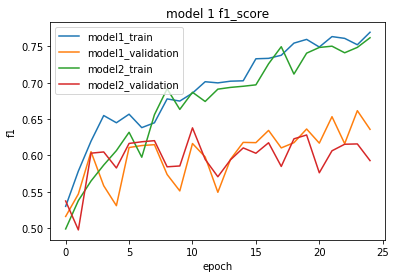

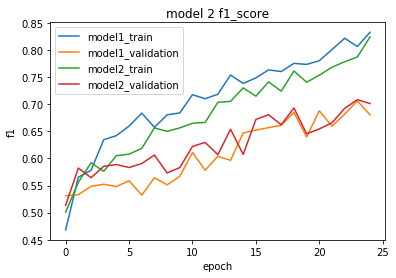

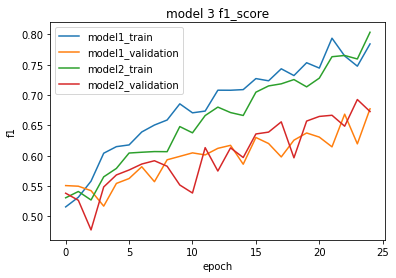

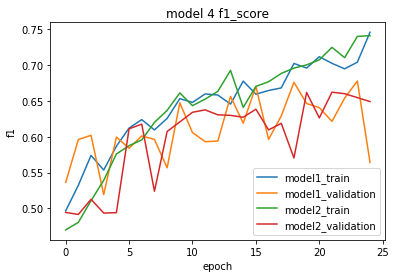

In [292]:
for i in range (4):
    plot_im(history_list[i],history_list[i+4],i+1)


Because there are too many lines in the figures above, we extract the better lines in model 1,2,3. The reason that we don't choose the line of model 4 is that it performs bad.  

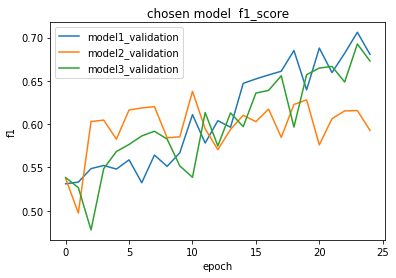

In [293]:
plt.plot()  
plt.plot(history_list[1].history['val_f1'])
plt.plot(history_list[4].history['val_f1'])
plt.plot(history_list[6].history['val_f1'])
plt.title('chosen model  f1_score' )  
plt.ylabel('f1')  
plt.xlabel('epoch')  
plt.legend(['model1_validation', 'model2_validation','model3_validation'], loc='best')  
plt.show()  

Here we can see model 1 performs best.

In [302]:
from sklearn.metrics import f1_score, confusion_matrix
def confusion_f1(model, test_data, test_target, normalize=True):
    target_int = np.argmax(test_target, axis=1)
    yhat = np.argmax(model.predict(X_test), axis=1)
    conf = confusion_matrix(target_int, yhat[:,np.newaxis])
    print('F1 score of this model is {}'.format(f1_score(target_int, yhat, average='micro')))
    print(conf)

Let's see the confusion metrics to see the actual classification results by each model in the test set.

In [303]:
confusion_f1(model_list[1],X_test, y_test_ohe)
confusion_f1(model_list[4],X_test, y_test_ohe)
confusion_f1(model_list[6],X_test, y_test_ohe)

F1 score of this model is 0.665
[[ 91 109]
 [ 25 175]]
F1 score of this model is 0.6325
[[152  48]
 [ 99 101]]
F1 score of this model is 0.6575
[[150  50]
 [ 87 113]]


In our test set, model 1 perform best. Which is the same as the result of the cross validation set. The conclusion that we got is because we have equal importance of positive and negative. This can not use in the other instances.

# 3. Exceptional Work

## 3.1 t-SNE Dimensionality Reduction

Use t-SNE to visualize the word embeddings of a subset of words in our vocabulary. 

We choosed several words and made the t-SNE dimensionality reduction.

In [255]:
wd_use=['music','song','near','close','wonderful','excellent','terrible','awful']
str_use=[]
for i in wd_use:
    str_use.append(embeddings_index[i])

In [234]:
str_use

[array([  1.27049997e-01,   3.72530013e-01,   2.30759993e-01,
         -1.07270002e-01,   1.42729998e+00,   7.79900014e-01,
         -5.50090000e-02,  -1.89089999e-01,  -4.28279996e-01,
          2.84429997e-01,   1.19199999e-01,  -6.19780004e-01,
         -3.98169994e-01,   1.91269994e-01,  -3.20980012e-01,
         -2.41160005e-01,   6.09269977e-01,  -3.57650012e-01,
          2.01590002e-01,   9.11069989e-01,  -4.89769995e-01,
         -2.89700001e-01,   1.00979996e+00,  -6.61490023e-01,
          7.04139993e-02,   1.33530006e-01,   4.22340006e-01,
         -8.01879987e-02,   1.07219994e+00,   2.64259994e-01,
         -7.39820004e-01,   6.49580002e-01,  -4.83669996e-01,
          8.58370006e-01,  -3.90080005e-01,  -1.30199999e-01,
          2.23309994e-01,   2.08179995e-01,  -4.72600013e-01,
         -1.72749996e+00,   3.72090012e-01,   5.55440009e-01,
         -8.90250027e-01,   8.74419987e-01,  -2.90630013e-01,
         -7.11749971e-01,  -3.34369987e-01,  -4.11410004e-01,
        

In [257]:
from sklearn.manifold import TSNE
X_tsne = TSNE(learning_rate=100).fit_transform(str_use)


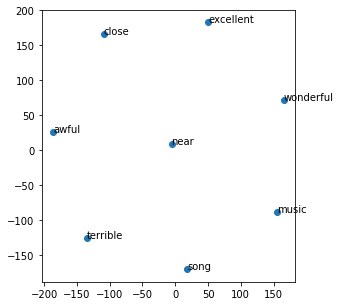

In [254]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
for i in range(8):
    plt.text(X_tsne[i,0],X_tsne[i,1],wd_use[i])

Here we can see the distribution of these words. We think each dimension reflects distance. The effect achieved by t-SNE is that in the original space, the distance is far away, then in the new low-dimensional space, the distance is also far; in the original space, the distance is close, then in the new low-dimensional space, the distance is also close. 

## 3.2 Generating Novel Text

This part is not required but is very attractive. we tried to use the structure on the internet and change the novel.txt and hyper-parameters.

https://github.com/mineshmathew/char_rnn_karpathy_keras/blob/master/char_rnn_of_karpathy_keras.py

The novel.txt we used is: After Twenty Years--O.Henry

In [399]:

text = open('novel.txt').read().lower()
print('corpus length:', len(text))
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen+1, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i+1:i +1+ maxlen])

print('nb sequences:', len(sentences))

X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences),maxlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1

for i, sentence in enumerate(next_chars):
    for t, char in enumerate(sentence):
        y[i, t, char_indices[char]] = 1
    



corpus length: 6751
total chars: 39
nb sequences: 6712


Create a RNN for generating novel text. 

In [402]:

model = Sequential()
rnn.add(embedding_layer)
model.add(LSTM(512, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(len(chars))))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [403]:
history=model.fit(X, y, batch_size=128,epochs=10,verbose=1)

Epoch 1/10
6712/6712 [==============================] - 125s 19ms/step - loss: 3.1498
Epoch 2/10
6712/6712 [==============================] - 121s 18ms/step - loss: 2.7577
Epoch 3/10
6712/6712 [==============================] - 122s 18ms/step - loss: 2.3190
Epoch 4/10
6712/6712 [==============================] - 123s 18ms/step - loss: 1.9774
Epoch 5/10
6712/6712 [==============================] - 126s 19ms/step - loss: 1.5777
Epoch 6/10
6712/6712 [==============================] - 124s 19ms/step - loss: 1.1222
Epoch 7/10
6712/6712 [==============================] - 124s 18ms/step - loss: 0.7293
Epoch 8/10
6712/6712 [==============================] - 120s 18ms/step - loss: 0.5042
Epoch 9/10
6712/6712 [==============================] - 121s 18ms/step - loss: 0.4016
Epoch 10/10
6712/6712 [==============================] - 117s 17ms/step - loss: 0.3435


In [406]:
import sys
seed_string="The waiting man pulled out a handsome watch" 
print ("seed string -->", seed_string)
print ('The generated text is')
sys.stdout.write(seed_string),

for i in range(1000):
    x=np.zeros((1, len(seed_string[-40:]), len(chars)))
    for tt, char in enumerate(seed_string[-40:]):
        x[0, tt, char_indices[char]] = 1.
    preds = model.predict(x, verbose=0)[0]
    next_index=np.argmax(preds[len(seed_string[-40:])-1])
    next_char = indices_char[next_index]
    seed_string = seed_string + next_char
    sys.stdout.write(next_char)
sys.stdout.flush()

seed string --> The waiting man pulled out a handsome watch
The generated text is
The waiting man pulled out a handsome watch, the lids of it set with small diamonds.

"three minutes to ten," he announced. "it was exactly ten o'clock when we parted here at the restaurant door."

"did pretty well out west, didn't you?" asked the policeman.

"you bet! i hope jimmy wells," he snapped. "twenty years is a long time, but not long enough to change a man's nose from a roman to a pug."

"it sometimes changes a good man into a bad one, said the tall man. "you've been under arrest for ten minutes, 'silky' bob. chicago thinks you may have dropped over our way and wires us she wants to have a chat with you. going quietly, are you? that's sensible. now, before we go on to the station here's a note i was asked to hand you. you may read it here at the window. it's from patrolman wells."

the man from the west unfolded the little piece of paper handed him. his hand was steady when he began to read, but

We began with a sentence in the novel. The output seems interesting. It is kind of fluent, but the context does not have strong relationship. There are lots of work that we can do.